### webscarpping of images

In [ ]:
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import requests

def save_image(img_url, save_path, img_name):
    response = requests.get(img_url, stream=True)
    with open(os.path.join(save_path, img_name), 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Image {img_name} downloaded successfully")

def scrape_images(query, num_images, save_path, class_name):
    driver_path = "chromedriver.exe" # Update this path to your ChromeDriver location
    chrome_service = Service(executable_path=driver_path)
    driver = webdriver.Chrome(service=chrome_service)

    os.makedirs(os.path.join(save_path, class_name), exist_ok=True)
    img_count = 0
    page_num = 1
    while img_count < num_images:
        search_url = f"https://www.google.com/search?q=cat+images&tbm=isch&ved=2ahUKEwi2xK3dw-6FAxWmU6QEHeUbC00Q2-cCegQIABAA&oq=cat+images&gs_lp=EgNpbWciCmNhdCBpbWFnZXMyBBAjGCcyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyChAAGIAEGEMYigUyBRAAGIAESO0WUOYFWMMQcAB4AJABAJgB8wGgAbYMqgEDMi03uAEDyAEA-AEBigILZ3dzLXdpei1pbWfCAg0QABiABBixAxhDGIoFwgIIEAAYgAQYsQOIBgE&sclient=img&ei=FEwzZrbqPKankdUP5bes6AQ&bih=926&biw=2048&prmd=ivsnbz&rlz=1C1KNTJ_enPK1085PK1085/?q={query}+{class_name}&tbm=isch&p={page_num}"
        driver.get(search_url)

        try:
            WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "img")))
        except TimeoutException:
            print(f"TimeoutException: The images for class {class_name} were not found within the specified timeout.")
            driver.quit()
            return

        # Scroll down to load more images
        for _ in range(10): # Adjust the range based on how many scrolls are needed to load more images
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2) # Wait for images to load

        img_elements = driver.find_elements(By.CSS_SELECTOR, "img")
        for i, img_element in enumerate(img_elements):
            if img_count >= num_images:
                break
            try:
                img_url = img_element.get_attribute("src")
                img_name = f"{class_name}_{img_count+1}.jpg"
                save_image(img_url, os.path.join(save_path, class_name), img_name)
                img_count += 1
            except Exception as e:
                print(f"Failed to download image {img_count+1} for class {class_name}: {e}")

        # Attempt to click the "Next" button to navigate to the next page
        try:
            next_button = driver.find_element(By.CSS_SELECTOR, "button.next") # Adjust the CSS selector as needed
            next_button.click()
            time.sleep(2) # Wait for the next page to load
            page_num += 1
        except Exception as e:
            print(f"Failed to navigate to the next page for class {class_name}: {e}")
            break # Exit the loop if the "Next" button is not found or cannot be clicked

    driver.quit()

# Example usage
save_path = "dataset"

# Define the classes you want to scrape
classes = ["cats"]

for class_name in classes:
    query = class_name
    num_images = 500
    scrape_images(query, num_images, save_path, class_name)

### resizing images

In [ ]:
import cv2
import os

def resize_images(dataset_path, output_path, size=(224, 224)):
    """
    Resize images in the dataset for CNN classification.

    :param dataset_path: Path to the dataset directory containing class subdirectories.
    :param output_path: Path to the output directory where resized images will be saved.
    :param size: Tuple specifying the new size for the images. Default is (224, 224).
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Iterate over each class subdirectory
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            # Create a subdirectory in the output path for the current class
            os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

            # Iterate over each image in the class subdirectory
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                if os.path.isfile(image_path):
                    # Read the image
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Resize the image
                        resized_image = cv2.resize(image, size)
                        # Save the resized image in the output directory
                        output_image_path = os.path.join(output_path, class_name, image_name)
                        cv2.imwrite(output_image_path, resized_image)
                        print(f"Resized image {image_name} and saved to {output_image_path}")

# Example usage
dataset_path = '/content/improved-project1/dataset' # Path to your dataset directory
output_path = 'resized_dataset' # Path to the directory where resized images will be saved
resize_images(dataset_path, output_path)

### preprocessing and importing folders

In [ ]:
!unzip /content/improved-project1.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf

In [4]:
# Define the paths to the clear and rainy folders
cat_folder = "/content/resized_dataset/cat"
dog_folder = "/content/resized_dataset/dog"

In [5]:
#Load cat images and labels
cat_images = []
cat_labels = []
for filename in os.listdir(cat_folder):
    img_path = os.path.join(cat_folder, filename)
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        img = cv2.imread(img_path)
        cat_images.append(img)
        cat_labels.append(0)  # Label 0 for cat

In [6]:
# Load dog images and labels
dog_images = []
dog_labels = []
for filename in os.listdir(dog_folder):
    img_path = os.path.join(dog_folder, filename)
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        img = cv2.imread(img_path)
        dog_images.append(img)
        dog_labels.append(1)  # Label 1 for dog

In [7]:

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

### Simple multilayer perceptron - 64.8% accuracy

In [8]:
# Split data into train and test sets
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print("Original shape of x_train:", x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)


Original shape of x_train: (740, 224, 224, 3) (185, 224, 224, 3) (740,) (185,)


In [10]:
# Flatten each image into a 1D array of size 224*224*3
x_train1 = x_train1.reshape((x_train1.shape[0], 224*224*3)).astype('float32') / 255
x_test1 = x_test1.reshape((x_test1.shape[0], 224*224*3)).astype('float32') / 255

In [11]:
x_train1.shape

(740, 150528)

In [12]:
from keras.utils import to_categorical
y_train1 = to_categorical(y_train1)
y_test1 = to_categorical(y_test1)

In [13]:
y_train1.shape

(740, 2)

In [14]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(224*224*3,)),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

In [17]:
import json

model_json = model.to_json()
with open("/content/model_perceptron.json", "w") as json_file:
    json_file.write(model_json)


In [18]:
# prompt: save in yml

import yaml

# Convert the model to JSON
model_json = model.to_json()

# Create a dictionary to store the model and its configuration
model_dict = {
    "model": model_json,
    "training_config": {
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
}

# Save the model and its configuration to a YAML file
with open("/content/model_perceptron.yml", "w") as yaml_file:
    yaml.dump(model_dict, yaml_file, default_flow_style=False)


In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

#add early stopping
es = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(x_train1, y_train1, epochs=100, validation_data=(x_test1, y_test1), callbacks=[es])

#evaluate the model
#model.evaluate(x_test1, y_test1)


#history = model.fit(x_train1, y_train1, epochs=49, validation_data=(x_test1, y_test1))


Epoch 1/100
24/24 [==============================] - 4s 39ms/step - loss: 5.3485 - accuracy: 0.5135 - val_loss: 2.0694 - val_accuracy: 0.5297
Epoch 2/100
24/24 [==============================] - 0s 20ms/step - loss: 2.2097 - accuracy: 0.5135 - val_loss: 1.6634 - val_accuracy: 0.6000
Epoch 3/100
24/24 [==============================] - 1s 21ms/step - loss: 0.9740 - accuracy: 0.6284 - val_loss: 0.7970 - val_accuracy: 0.6703
Epoch 4/100
24/24 [==============================] - 0s 19ms/step - loss: 0.9094 - accuracy: 0.6459 - val_loss: 2.1500 - val_accuracy: 0.4811
Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 1.2085 - accuracy: 0.5635 - val_loss: 0.9620 - val_accuracy: 0.5676
Epoch 6/100
24/24 [==============================] - 0s 19ms/step - loss: 0.8603 - accuracy: 0.6176 - val_loss: 0.6516 - val_accuracy: 0.6432
Epoch 7/100
24/24 [==============================] - 0s 20ms/step - loss: 0.7450 - accuracy: 0.6257 - val_loss: 0.8159 - val_accuracy: 0.6865
Epoch 

In [21]:
test_loss, test_acc = model.evaluate(x_test1, y_test1) # will give test data acccuracy
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 11ms/step - loss: 0.7179 - accuracy: 0.6486
Test accuracy: 0.6486486196517944


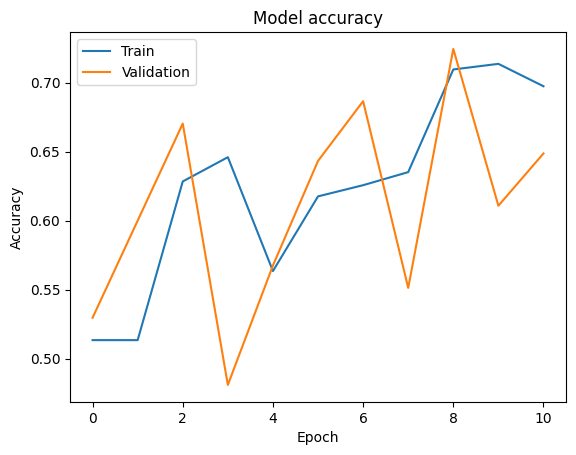

In [22]:
import matplotlib.pyplot as plt
#plot the history of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [24]:
model.save('perceptron.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Shallow CNN model - 70% accuracy

In [26]:
# Split data into train and test sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from keras.utils import to_categorical
y_train2 = to_categorical(y_train2)
y_test2 = to_categorical(y_test2)

In [28]:
x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape  #here we see that our target variable y train and y test has 2 classes so therefore we put 2 in output dense layer

((740, 224, 224, 3), (185, 224, 224, 3), (740, 2), (185, 2))

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    #MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    #MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

In [33]:

# Convert the model to JSON
model_json = model.to_json()

# Create a dictionary to store the model and its configuration
model_dict = {
    "model": model_json,
    "training_config": {
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
}

# Save the model and its configuration to a YAML file
with open("/content/model_shallowCNN.yml", "w") as yaml_file:
    yaml.dump(model_dict, yaml_file, default_flow_style=False)


In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
#add early stopping
es = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(x_train2, y_train2, epochs=100, validation_data=(x_test2, y_test2), callbacks=[es])

#evaluate the model
model.evaluate(x_test2, y_test2)

#history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/100
24/24 [==============================] - 15s 290ms/step - loss: 4714.3447 - accuracy: 0.5054 - val_loss: 6.6440 - val_accuracy: 0.6595
Epoch 2/100
24/24 [==============================] - 4s 183ms/step - loss: 0.9400 - accuracy: 0.8554 - val_loss: 1.8478 - val_accuracy: 0.6108
Epoch 3/100
24/24 [==============================] - 5s 194ms/step - loss: 0.1793 - accuracy: 0.9635 - val_loss: 1.7354 - val_accuracy: 0.6649
Epoch 4/100
24/24 [==============================] - 5s 188ms/step - loss: 0.0771 - accuracy: 0.9838 - val_loss: 1.8999 - val_accuracy: 0.6649
Epoch 5/100
24/24 [==============================] - 5s 192ms/step - loss: 0.0487 - accuracy: 0.9905 - val_loss: 1.4071 - val_accuracy: 0.6811
Epoch 6/100
24/24 [==============================] - 5s 195ms/step - loss: 0.2092 - accuracy: 0.9811 - val_loss: 1.1891 - val_accuracy: 0.6973
Epoch 7/100
24/24 [==============================] - 4s 185ms/step - loss: 0.0572 - accuracy: 0.9838 - val_loss: 2.5524 - val_accuracy: 0.

[2.8584017753601074, 0.7027027010917664]

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test2, y_test2)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 0s 40ms/step - loss: 2.8584 - accuracy: 0.7027
Test Accuracy: 0.7027027010917664


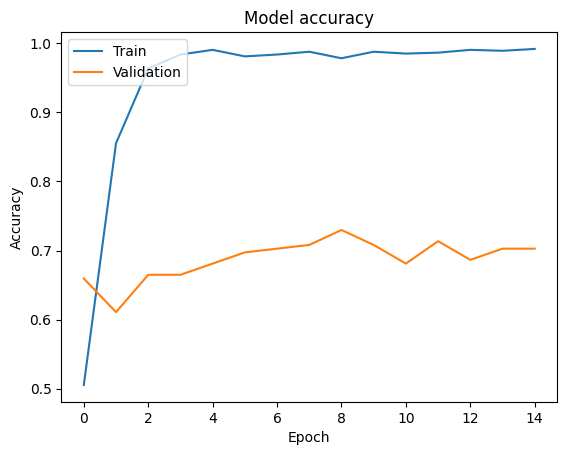

In [34]:
#plot the history of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:

model.save('shallow_cnn.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Deep CNN model - 77.8% accuracy

In [35]:
# Split data into train and test sets
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from keras.utils import to_categorical
y_train3 = to_categorical(y_train3)
y_test3 = to_categorical(y_test3)

In [37]:
x_train3.shape, x_test3.shape, y_train3.shape, y_test3.shape  #here we see that our target variable y train and y test has 2 classes so therefore we put 2 in output dense layer

((740, 224, 224, 3), (185, 224, 224, 3), (740, 2), (185, 2))

In [40]:
# Define the deep CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),

    # Flatten the tensor output from the convolutional layers
    Flatten(),

    # Fully connected layer
    Dense(2, activation='softmax') # Assuming binary classification
])

In [41]:
# prompt: save the deep cnn model architecture in yml format

# Convert the model to JSON
model_json = model.to_json()

# Create a dictionary to store the model and its configuration
model_dict = {
    "model": model_json,
    "training_config": {
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
}

# Save the model and its configuration to a YAML file
with open("/content/model_deepCNN.yml", "w") as yaml_file:
    yaml.dump(model_dict, yaml_file, default_flow_style=False)


In [42]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
#add early stopping
es = EarlyStopping(monitor='val_loss', patience=5, mode='min')
history1 = model.fit(x_train3, y_train3, epochs=6, validation_data=(x_test3, y_test3), callbacks=[es])

#evaluate the model
#model.evaluate(x_test3, y_test3)

#history = model.fit(x_train3, y_train3, epochs=30, validation_data=(x_test3, y_test3))


Epoch 1/6
24/24 [==============================] - 6s 248ms/step - loss: 0.0524 - accuracy: 0.9892 - val_loss: 2.8770 - val_accuracy: 0.6486
Epoch 2/6
24/24 [==============================] - 6s 246ms/step - loss: 0.0435 - accuracy: 0.9919 - val_loss: 1.6568 - val_accuracy: 0.6703
Epoch 3/6
24/24 [==============================] - 6s 247ms/step - loss: 0.0684 - accuracy: 0.9919 - val_loss: 1.2505 - val_accuracy: 0.7189
Epoch 4/6
24/24 [==============================] - 6s 249ms/step - loss: 0.0578 - accuracy: 0.9878 - val_loss: 1.5421 - val_accuracy: 0.6757
Epoch 5/6
24/24 [==============================] - 6s 240ms/step - loss: 0.0909 - accuracy: 0.9932 - val_loss: 1.2889 - val_accuracy: 0.7081
Epoch 6/6
24/24 [==============================] - 6s 249ms/step - loss: 0.0864 - accuracy: 0.9865 - val_loss: 0.7512 - val_accuracy: 0.7784


In [46]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test3, y_test3)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 0s 76ms/step - loss: 0.7512 - accuracy: 0.7784
Test Accuracy: 0.7783783674240112


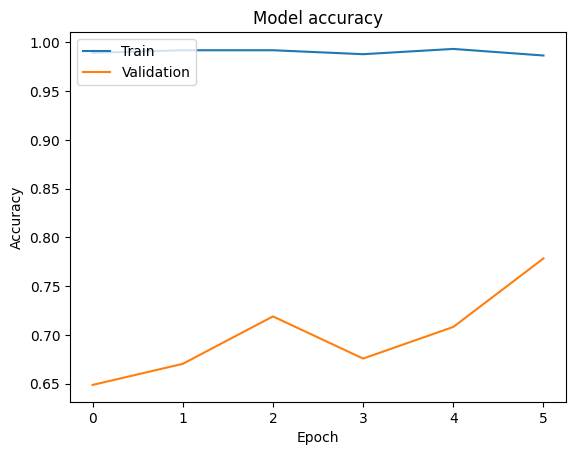

In [47]:
#plot the history of the model
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Bench mark models - 95% accuracy

In [71]:
# Split data into train and test sets
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
from keras.utils import to_categorical
y_train4 = to_categorical(y_train4)
y_test4 = to_categorical(y_test4)

In [73]:
x_train4.shape, x_test4.shape, y_train4.shape, y_test4.shape  #here we see that our target variable y train and y test has 2 classes so therefore we put 2 in output dense layer

((740, 224, 224, 3), (185, 224, 224, 3), (740, 2), (185, 2))

In [74]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG16 model with pre-trained weights
#This code loads the VGG16 model with pre-trained weights from the ImageNet dataset.
# The include_top=False parameter means that the final fully connected layer, which is responsible for classification, is not included.
# This allows us to add our own fully connected layers at the end of the model, tailored to our specific task
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax') # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              25691136  
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dense_16 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 40931650 (156.14 MB)
Trainable params: 26216962 (100.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_____

In [76]:
# prompt: save the model architecture in yml format

# Convert the model to JSON
model_json = model.to_json()

# Create a dictionary to store the model and its configuration
model_dict = {
    "model": model_json,
    "training_config": {
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    }
}

# Save the model and its configuration to a YAML file
with open("/content/model_benchmark.yml", "w") as yaml_file:
    yaml.dump(model_dict, yaml_file, default_flow_style=False)


In [77]:

history = model.fit(x_train4, y_train4, epochs=10, validation_data=(x_test4, y_test4))


Epoch 1/10
24/24 [==============================] - 20s 492ms/step - loss: 9.3577 - accuracy: 0.8622 - val_loss: 2.5854 - val_accuracy: 0.9405
Epoch 2/10
24/24 [==============================] - 5s 193ms/step - loss: 0.3193 - accuracy: 0.9824 - val_loss: 2.2390 - val_accuracy: 0.9351
Epoch 3/10
24/24 [==============================] - 4s 173ms/step - loss: 0.2811 - accuracy: 0.9946 - val_loss: 1.3255 - val_accuracy: 0.9622
Epoch 4/10
24/24 [==============================] - 5s 192ms/step - loss: 0.0994 - accuracy: 0.9946 - val_loss: 1.0171 - val_accuracy: 0.9622
Epoch 5/10
24/24 [==============================] - 4s 168ms/step - loss: 0.2519 - accuracy: 0.9932 - val_loss: 1.3191 - val_accuracy: 0.9568
Epoch 6/10
24/24 [==============================] - 4s 188ms/step - loss: 0.1673 - accuracy: 0.9905 - val_loss: 1.6057 - val_accuracy: 0.9514
Epoch 7/10
24/24 [==============================] - 4s 187ms/step - loss: 0.1391 - accuracy: 0.9946 - val_loss: 1.6844 - val_accuracy: 0.9514
Epoch

In [78]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test4, y_test4)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 1s 124ms/step - loss: 1.7330 - accuracy: 0.9514
Test Accuracy: 0.9513513445854187


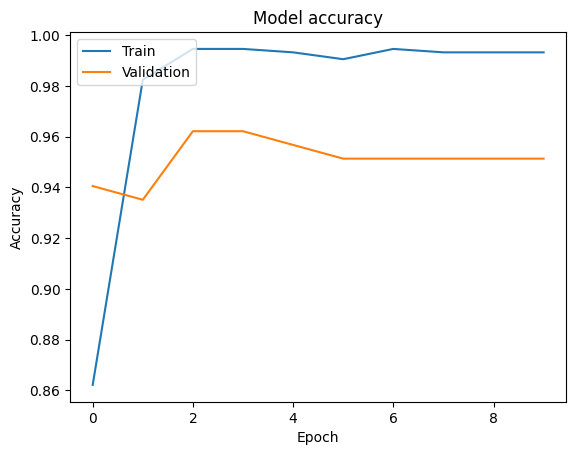

In [79]:
#plot the history of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Streamlit app - python script run
